# Building Text Classifier with Logit-Lasso

In today's review session, we are going to go over how to build the simplest text analysis.

## Webscraping with APIs

Many of you are interested in analyzing Twitter sentiments or New York Times headlines. Luckily, there are Python APIs (application programming interfaces) that allow us to retrieve data directly.

In [56]:
import requests
from pprint import pprint
import pandas as pd
import time
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

For example, the New York Times offers a few APIs that allow us to extract archive data, or most viewed articles. I will go over below how to extract headlines and abstracts from archives, but see [here](https://developer.nytimes.com/apis) for more information on other NY Times apis.

In [2]:
api_key = 'Your Key'
year = 2020
month = 1
response = requests.get(f'https://api.nytimes.com/svc/archive/v1/{year}/{month}.json?api-key={api_key}')

The requests returns the extracted entries in json format. 

In [3]:
content = response.json()

Here is what each entry looks like. Some of the information available includes abstract, headline, and section name. 

In [4]:
content['response']['docs'][0]

{'abstract': 'The gunman who shot two parishioners at the West Freeway Church of Christ had come earlier looking for food and money, church leaders said.',
 'web_url': 'https://www.nytimes.com/2019/12/31/us/texas-church-shooting-white-settlement.html',
 'snippet': 'The gunman who shot two parishioners at the West Freeway Church of Christ had come earlier looking for food and money, church leaders said.',
 'lead_paragraph': 'WHITE SETTLEMENT, Texas — Given West Freeway Church of Christ’s location, on a busy thoroughfare just off a major highway, vagabonds and homeless people regularly found their way inside. Sometimes, they sought spiritual help. But more often, they came asking for food, which the church would provide, and money, which it typically would not. ',
 'print_section': 'A',
 'print_page': '16',
 'source': 'The New York Times',
 'multimedia': [{'rank': 0,
   'subtype': 'xlarge',
   'caption': None,
   'credit': None,
   'type': 'image',
   'url': 'images/2019/12/31/us/31TEXAS

We can iterate through the loaded json to retrieve headlines and abstracts.

In [43]:
nyt_headlines = []
nyt_abstract = []
nyt_sections = []
nyt_dates = []
for month in [1, 2, 3]:
    response = requests.get(f'https://api.nytimes.com/svc/archive/v1/{year}/{month}.json?api-key={api_key}')
    content = response.json()
    for article in content['response']['docs']:
        nyt_headlines.append(article['headline']['main'])
        nyt_sections.append(article['section_name'])
        nyt_abstract.append(article['abstract'])
        nyt_dates.append(article['pub_date'])
    #time.sleep(5)
nyt_df = pd.DataFrame({'headline': nyt_headlines, 'abstract': nyt_abstract, 'date': nyt_dates, 'section': nyt_sections})
nyt_df_as = nyt_df[nyt_df['section'].isin(['Arts', 'Sports'])]
nyt_df_as

,headline,abstract,date,section
13,What’s on TV Wednesday: A Linda Ronstadt Doc a...,“Linda Ronstadt: The Sound of My Voice” airs o...,2020-01-01T06:00:06+0000,Arts
31,Couture Creations for Dancing Bodies,An exhibition at the Centre National du Costum...,2020-01-01T10:00:21+0000,Arts
49,Fearless Predictions for the N.B.A. in 2020,Breaking out the crystal roundball for some (a...,2020-01-01T15:00:03+0000,Sports
69,Review: Anna Netrebko Rings in the Year With a...,"The company’s prima donna showed off her past,...",2020-01-01T18:40:41+0000,Arts
70,"Woody Vasulka, Whose Video Art Extended Bounda...",He deftly manipulated electronic images to pro...,2020-01-01T18:49:54+0000,Arts
...,...,...,...,...
13576,How We Use Our Bodies to Navigate a Pandemic,"Your partner is a stranger, and the sidewalk i...",2020-03-31T21:26:25+0000,Arts
13577,"Jan Howard, Singer and Writer of Country Hits,...",A female star in Nashville when there weren’t ...,2020-03-31T21:29:16+0000,Arts
13582,International Center of Photography Wants Your...,"Artists, both professional and otherwise, can ...",2020-03-31T21:51:31+0000,Arts
13592,‘Tiger King’: What to Read if You’re Obsessed ...,Go on a deep dive with these articles that exp...,2020-03-31T22:54:35+0000,Arts


If we want to look at historical headlines, we will have to make multiple requests. Usually, for APIs, there are per minute or per day limits. To avoid reaching the limit, it is good to "sleep" between requests. 

In [84]:
toks = nyt_df_as['headline'].tolist()
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(toks)
features = vectorizer.get_feature_names_out()
X.shape

(1673, 4485)

In [83]:
y = (nyt_df_as['section']=='Arts').to_numpy()
y = nyt_df_as['section']
x = X.toarray()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1680)

In [82]:
test_scores = {}
max_score = 0
for c in [0.001, 0.01, 0.1, 1]:
    loglasso  = LogisticRegression(penalty='l1', solver='liblinear', random_state=1680, C=c).fit(x_train, y_train)
    test_score = loglasso.score(x_test, y_test)
    if test_score > max_score:
        best_model = loglasso
        max_score = test_score
    test_scores[c] = test_score

In [68]:
test_scores

{0.001: 0.6417910447761194,
 0.01: 0.6417910447761194,
 0.1: 0.6417910447761194,
 1: 0.7850746268656716}

In [80]:
coefs_df = pd.DataFrame({'Feature': features[(best_model.coef_ > 0)[0]], 'Coef': best_model.coef_[0][(best_model.coef_> 0)[0]]}).sort_values('Coef', ascending=False).reset_index(drop=True)
coefs_df.head(20)

,Feature,Coef
0,astros,5.967026
1,sports,5.338351
2,olympics,5.046799
3,soccer,4.767903
4,olympic,4.568830
5,basketball,4.307505
6,kobe,4.052509
7,bryant,3.292544
8,open,2.925145
9,mets,2.844911


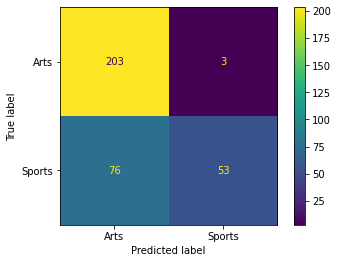

In [85]:
cm = confusion_matrix(y_test, best_model.predict(x_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot()